Epoch 1/10, Train Loss: 1.3141, Val Loss: 1.6635
Epoch 2/10, Train Loss: 1.2321, Val Loss: 1.4995


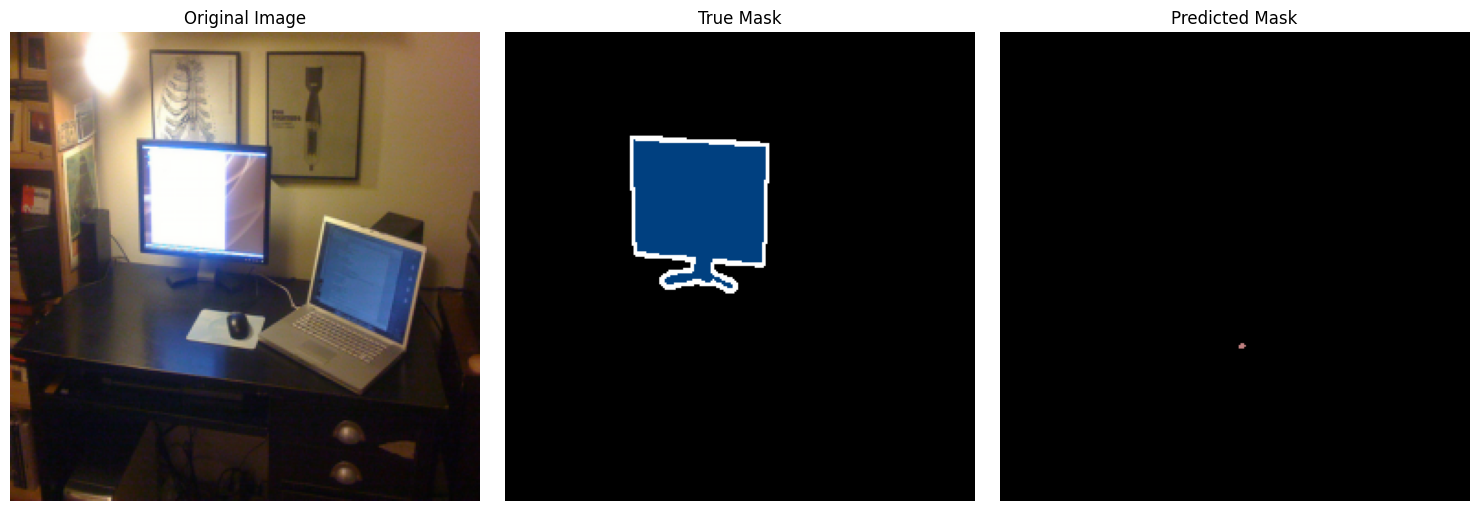

Epoch 3/10, Train Loss: 1.2193, Val Loss: 1.2223
Epoch 4/10, Train Loss: 1.2024, Val Loss: 1.2936


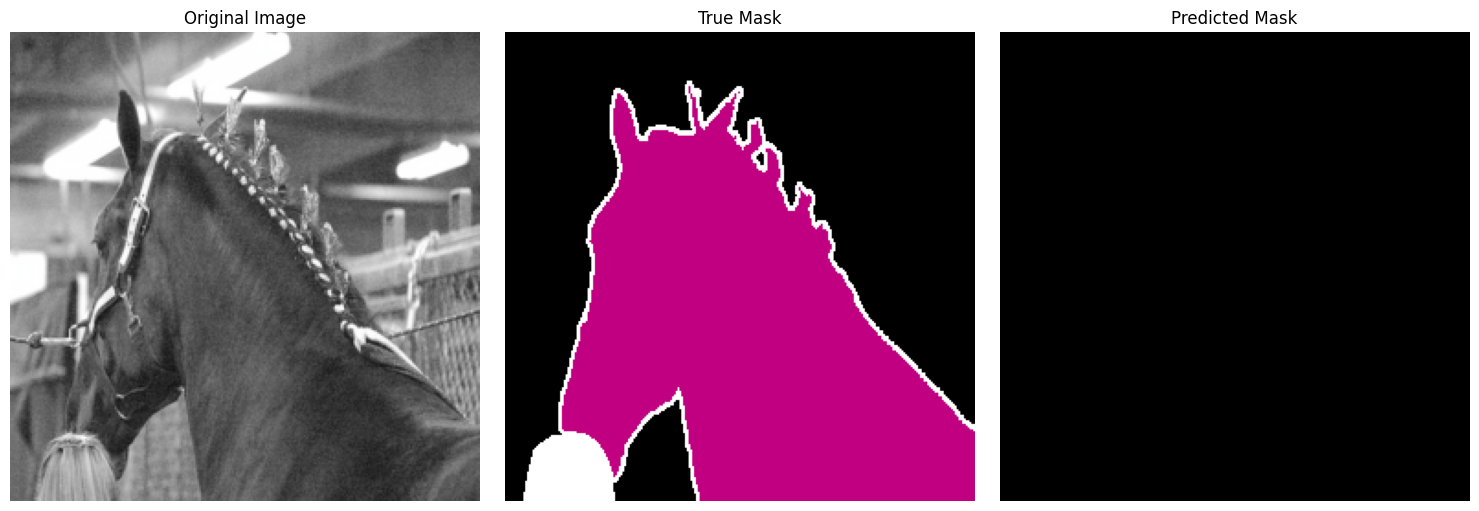

KeyboardInterrupt: 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import fcn_resnet50
import matplotlib.pyplot as plt
import numpy as np
from time import time
from PIL import Image

# Параметры
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 21  # VOC имеет 20 классов + фон
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Аугментации для изображений
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((256, 256)),
    ])

# Преобразования для масок
def get_target_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256), interpolation=Image.NEAREST),
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.squeeze().type(torch.long)),
    ])

# Загрузка датасета
train_dataset = VOCSegmentation(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=get_transforms(),
    target_transform=get_target_transforms()
)

val_dataset = VOCSegmentation(
    root='./data',
    year='2012',
    image_set='val',
    download=True,
    transform=get_transforms(),
    target_transform=get_target_transforms()
)

# Создание DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

# Инициализация модели
model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, NUM_CLASSES, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model = model.to(DEVICE)

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Функция для тренировки
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

# Функция для валидации
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            running_loss += loss.item()

    return running_loss / len(loader)

# Цвета для визуализации (палитра VOC + цвет для ignore_index=255)
VOC_COLORS = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128],  # 20 классов + фон
    [255, 255, 255]  # Добавляем белый цвет для ignore_index=255
], dtype=np.uint8)

# Функция для визуализации
def visualize_sample(model, dataset, device, num_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples)

    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        image, true_mask = dataset[idx]

        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))['out']
            pred_mask = output.argmax(1).squeeze().cpu().numpy()

        # Денормализация изображения
        image = image.cpu().numpy().transpose(1, 2, 0)
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)

        # Обработка масок (заменяем 255 на 21 для визуализации)
        true_mask = true_mask.numpy()
        true_mask_vis = np.where(true_mask == 255, NUM_CLASSES, true_mask)
        pred_mask_vis = np.where(pred_mask == 255, NUM_CLASSES, pred_mask)

        # Преобразование масок в цветные изображения
        true_mask_colored = VOC_COLORS[true_mask_vis]
        pred_mask_colored = VOC_COLORS[pred_mask_vis]

        # Отображение
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(true_mask_colored)
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_mask_colored)
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Тренировка модели
train_losses = []
val_losses = []

start_time = time()
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss = validate_epoch(model, val_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Визуализация после каждой эпохи
    if (epoch + 1) % 2 == 0:  # Визуализируем каждую 2-ю эпоху
        visualize_sample(model, val_dataset, DEVICE, num_samples=1)

print(f"Training completed in {(time() - start_time)/60:.2f} minutes")

# Визуализация кривых обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Финальная визуализация на валидационном наборе
visualize_sample(model, val_dataset, DEVICE, num_samples=3)